In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt
from random import seed # for setting seed
import tensorflow
from IPython import sys_info
import os
import gc # garbage collection
import random
import os
import shutil

In [ ]:
MY_SEED = 42 # 480 could work too
seed(MY_SEED)


print(sys_info())
# get module information
!pip freeze > frozen-requirements.txt
# append system information to file
with open("frozen-requirements.txt", "a") as file:
    file.write(sys_info())

{'commit_hash': 'fcc71cc32',
 'commit_source': 'installation',
 'default_encoding': 'utf-8',
 'ipython_path': '/usr/local/lib/python3.10/dist-packages/IPython',
 'ipython_version': '7.34.0',
 'os_name': 'posix',
 'platform': 'Linux-6.1.58+-x86_64-with-glibc2.35',
 'sys_executable': '/usr/bin/python3',
 'sys_platform': 'linux',
 'sys_version': '3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]'}


In [ ]:
from tensorflow.python.client import device_lib
# print out the CPUs and GPUs
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7588666484507063171
xla_global_id: -1
]


In [ ]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [ ]:
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Input

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
folder = '/content/drive/My Drive/PROJECTE DEEP LEARNING/TOP5_ARTISTS_WITH_100_PICTURES'

# List the files in the folder
all_pictures = os.listdir(folder)

file_path = "/content/drive/My Drive/PROJECTE DEEP LEARNING/TOP5_ARTISTS_WITH_100_PICTURES.csv"
df = pd.read_csv(file_path)
print(df.head())


         artist  date                  genre  pixelsx  pixelsy  size_bytes  \
0  Paul Gauguin  1903         genre painting   1916.0   1688.0    363138.0   
1  Paul Gauguin  1893               portrait   2048.0   1348.0    293452.0   
2  Paul Gauguin  1892  mythological painting   1800.0   1082.0   1638911.0   
3  Paul Gauguin  1903         genre painting   1600.0   1067.0    307130.0   
4  Paul Gauguin  1892               portrait   1096.0   1476.0    467406.0   

    source               style                  title    artist_group  \
0  wikiart  Post-Impressionism         The Invocation  train_and_test   
1  wikiart         Cloisonnism                  Alone  train_and_test   
2  wikiart         Cloisonnism          The Royal End  train_and_test   
3  wikiart  Post-Impressionism  Women and white horse  train_and_test   
4  wikiart  Post-Impressionism            Two sisters  train_and_test   

   in_train new_filename  
0     False    35323.jpg  
1     False    73683.jpg  
2      True

# Create Train and Test sets (only execute this if it's the first time)

In [ ]:
# GROUP THE FILES BY EACH ARTIST
def group_files_per_artist():
  data_per_artist = {}

  # Iterate over each row of the DataFrame
  for index, row in df.iterrows():
      artist = row['artist']
      new_filename = row['new_filename']

      # Check if the artist is already in the dictionary
      if artist in data_per_artist:
          # Add the new_filename to the existing list of the artist
          data_per_artist[artist].append(new_filename)
      else:
          # Create a new list for the artist and add the new_filename
          data_per_artist[artist] = [new_filename]

  return data_per_artist

# SPLIT THE FILES INTO TRAIN AND TEST SETS (CREATE NEW DATASETS)
def split_test_train(data_per_artist, train_percentage = 0.8):

  TRAIN_names = []
  TEST_names = []

  # Iterate over each artist and their 'new_filename'
  for artist, filenames in data_per_artist.items():
      # Calculate the number of files for training and testing
      total_files = len(filenames)
      num_train = int(train_percentage * total_files)

      # Shuffle the filenames to avoid selection biases
      random.shuffle(filenames)

      # Divide the filenames into train and test
      train_filenames = filenames[:num_train]
      test_filenames = filenames[num_train:]

      # Store the divided filenames into train and test
      TRAIN_names.extend(train_filenames)
      TEST_names.extend(test_filenames)
  return TRAIN_names, TEST_names



# CREATE TEST and TRAIN folders
def create_train_test_folders(folder, TRAIN_names, TEST_names):
    # Output folder for TRAIN and TEST
    train_folder = os.path.join(folder, 'TRAIN')
    test_folder = os.path.join(folder, 'TEST')

    # Create TRAIN and TEST folders if they don't exist
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Move images from TRAIN to TRAIN folder
    for filename in TRAIN_names:
        src = os.path.join(folder, filename)
        dst = os.path.join(train_folder, filename)
        shutil.move(src, dst)

    # Move images from TEST to TEST folder
    for filename in TEST_names:
        src = os.path.join(folder, filename)
        dst = os.path.join(test_folder, filename)
        shutil.move(src, dst)

    # Create df_train with rows whose 'new_filename' is in TRAIN_names and keep only 'artist' and 'new_filename' columns
    train_dataframe = df[df['new_filename'].isin(TRAIN_names)][['artist', 'new_filename']]
    # File path for the CSV file
    file_path = os.path.join(folder, 'train_dataframe.csv')
    # Save the DataFrame as CSV
    train_dataframe.to_csv(file_path, index=False)

    # Create df_test with rows whose 'new_filename' is in TEST_names and keep only 'artist' and 'new_filename' columns
    test_dataframe = df[df['new_filename'].isin(TEST_names)][['artist', 'new_filename']]
    # File path for the CSV file
    file_path = os.path.join(folder, 'test_dataframe.csv')
    # Save the DataFrame as CSV
    test_dataframe.to_csv(file_path, index=False)

    return train_dataframe, test_dataframe

if not (os.path.exists(os.path.join(folder, 'TRAIN')) and os.path.exists(os.path.join(folder, 'TEST'))):
  # Group files per artist
  data_per_artist = group_files_per_artist()
  # Print the number of files for each artist
  print("- Artists and numer of images:")
  for key in data_per_artist.keys():
    print(key, len(data_per_artist[key]))

  # Split data
  TRAIN_names, TEST_names = split_test_train(data_per_artist)

  # Use the function to create TRAIN and TEST folders
  train_dataframe, test_dataframe = create_train_test_folders(folder, TRAIN_names, TEST_names)
  print("\nImages successfully moved to TRAIN and TEST folders.")
else:
  print("TRAIN and TEST folders already exist. Reading train and test DataFrames from CSV files...")

  # Read train and test DataFrames from CSV files
  train_csv_path = os.path.join(folder, 'train_dataframe.csv')
  test_csv_path = os.path.join(folder, 'test_dataframe.csv')
  train_dataframe = pd.read_csv(train_csv_path)
  test_dataframe = pd.read_csv(test_csv_path)

  print("Train DataFrame:", train_dataframe.shape)
  print("Test DataFrame:", test_dataframe.shape)

Paul Gauguin 100
Martiros Saryan 100
Vincent van Gogh 100
Marc Chagall 100
John Singer Sargent 100


# Create the Model

In [ ]:
num_classes = len(data_per_artist.keys())  # one class per artist
print(num_classes)
weights_notop_path = '/content/drive/My Drive/PROJECTE DEEP LEARNING/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

model = Sequential()

# Add ResNet50 without the top dense layer
model.add(ResNet50(include_top=False, pooling='avg', input_shape=(224, 224, 3)))

# Add a dense layer with softmax activation for classification
model.add(Dense(num_classes, activation='softmax'))

# Freeze the layers of ResNet50 so they are not trained during the first training
model.layers[0].trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display a summary of the model
model.summary()


5
94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 23597957 (90.02 MB)
Trainable params: 10245 (40.02 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
# model globals
IMAGE_SIZE = 224
BATCH_SIZE = 40
TEST_BATCH_SIZE = 10 # because test has 100 images and factors of 100 are 10*10
                     # it is important that this number evenly divides the total num images
VAL_SPLIT = 0.25

# Train the Model

In [ ]:
def setup_generators(
    val_split, train_dataframe, train_dir,
    img_size, batch_size, my_seed, list_of_classes,
    test_dataframe, test_dir, test_batch_size
):
    print("-"*20)
    if not preprocess_input:
          raise Exception("please do import call 'from tensorflow.keras.applications.resnet50 import preprocess_input'")

    # setup resnet50 preprocessing
    data_gen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        validation_split=val_split)

    print(len(train_dataframe), "images in", train_dir, "and validation_split =", val_split)
    print("\ntraining set ImageDataGenerator")
    train_gen = data_gen.flow_from_dataframe(
        dataframe=train_dataframe.reset_index(), # call reset_index() so keras can start with index 0
        directory=train_dir,
        x_col='new_filename',
        y_col='artist',
        has_ext=True,
        target_size=(img_size, img_size),
        subset="training",
        batch_size=batch_size,
        seed=my_seed,
        shuffle=True,
        class_mode='categorical',
        classes=list_of_classes
    )

    print("\nvalidation set ImageDataGenerator")
    valid_gen = data_gen.flow_from_dataframe(
        dataframe=train_dataframe.reset_index(), # call reset_index() so keras can start with index 0
        directory=train_dir,
        x_col='new_filename',
        y_col='artist',
        has_ext=True,
        subset="validation",
        batch_size=batch_size,
        seed=my_seed,
        shuffle=True,
        target_size=(img_size,img_size),
        class_mode='categorical',
        classes=list_of_classes
    )

    test_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

    print("\ntest set ImageDataGenerator")
    test_gen = test_data_gen.flow_from_dataframe(
        dataframe=test_dataframe.reset_index(), # call reset_index() so keras can start with index 0
        directory=test_dir,
        x_col='new_filename',
        y_col=None,
        has_ext=True,
        batch_size=test_batch_size,
        seed=my_seed,
        shuffle=False, # dont shuffle test directory
        class_mode=None,
        target_size=(img_size,img_size)
    )

    return (train_gen, valid_gen, test_gen)

print("defined setup_generators()")

defined setup_generators()


In [ ]:
train_dir = folder+"/TRAIN"
test_dir = folder+"/TEST"
train_gens, valid_gens, test_gen = setup_generators(
        VAL_SPLIT, train_dataframe, train_dir,
      IMAGE_SIZE, BATCH_SIZE, MY_SEED, list(set(train_dataframe["artist"].tolist())),
      test_dataframe, test_dir, TEST_BATCH_SIZE
    )




--------------------
400 images in /content/drive/My Drive/PROJECTE DEEP LEARNING/TOP5_ARTISTS_WITH_100_PICTURES/TRAIN and validation_split = 0.25

training set ImageDataGenerator
Found 300 validated image filenames belonging to 5 classes.

validation set ImageDataGenerator
Found 100 validated image filenames belonging to 5 classes.

test set ImageDataGenerator
Found 100 validated image filenames.


In [ ]:
# the tutorial had 10 epochs...
MAX_EPOCHS = 8
DIR_EPOCHS = 1 # fit each train_dir at least this many times before overfitting

In [ ]:
histories = []

e=0
while ( e < MAX_EPOCHS):
    # train_gen.n = number of images for training
    STEP_SIZE_TRAIN = train_gens.n//train_gens.batch_size
    # train_gen.n = number of images for validation
    STEP_SIZE_VALID = valid_gens.n//valid_gens.batch_size
    print("STEP_SIZE_TRAIN",STEP_SIZE_TRAIN)
    print("STEP_SIZE_VALID",STEP_SIZE_VALID)
    histories.append(
        model.fit_generator(generator=train_gens,
                            steps_per_epoch=STEP_SIZE_TRAIN,
                            validation_data=valid_gens,
                            validation_steps=STEP_SIZE_VALID,
                          epochs=DIR_EPOCHS)
      )
    e+=1

STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2


<ipython-input-19-973ec152ec2c>:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=train_gens,


7/7 [==============================] - 142s 19s/step - loss: 1.5419 - accuracy: 0.3538 - val_loss: 6.1270 - val_accuracy: 0.1125
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 87s 13s/step - loss: 0.7699 - accuracy: 0.6885 - val_loss: 8.1854 - val_accuracy: 0.1125
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 84s 12s/step - loss: 0.4692 - accuracy: 0.8536 - val_loss: 8.8364 - val_accuracy: 0.1500
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 80s 11s/step - loss: 0.3247 - accuracy: 0.8962 - val_loss: 9.5776 - val_accuracy: 0.1125
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 77s 11s/step - loss: 0.2471 - accuracy: 0.9308 - val_loss: 9.4946 - val_accuracy: 0.1250
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 75s 11s/step - loss: 0.1859 - accuracy: 0.9538 - val_loss: 9.2599 - val_accuracy: 0.1750
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==========

# Evaluate the model

In [ ]:
histories

In [ ]:
accuracies = []
val_accuracies = []
losses = []
val_losses = []
for hist in histories:
    if hist:
        accuracies += hist.history["accuracy"]
        val_accuracies += hist.history['val_accuracy']
        losses += hist.history['loss']
        val_losses += hist.history['val_loss']

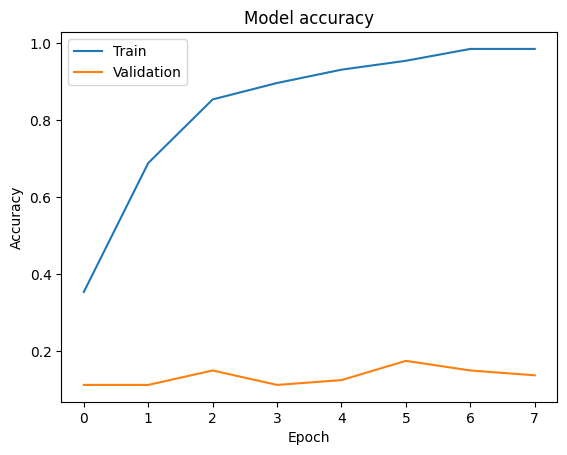

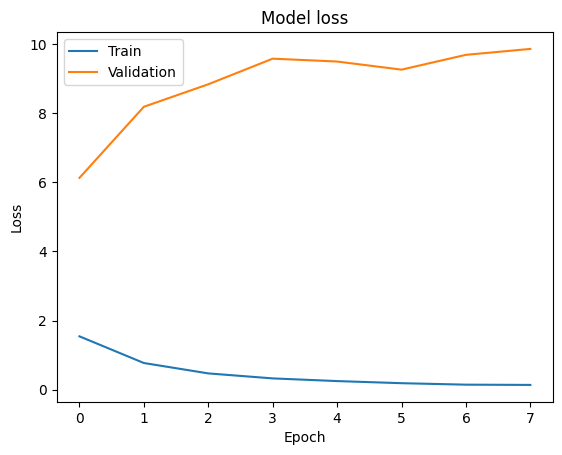

In [ ]:
# Plot training & validation accuracy values
plt.plot(accuracies)
plt.plot(val_accuracies)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(losses)
plt.plot(val_losses)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()